# DLC Live PyTorch Demo

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dlclive import DLCLive
import cv2
import numpy as np
from pathlib import Path
import time
from onnxruntime import quantization
import onnx
import onnxruntime as ort
import os

Loading DLC 3.0.0rc4...


In [3]:
projects = ["fly-kevin", "hand-track", "superbird", "ventral-gait"]

In [ ]:
from pathlib import Path
from dlclibrary import download_huggingface_model

# Creates a folder and downloads the model to it
model_dir = Path("/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/superanimal_quadruped_model_pytorch")
model_dir.mkdir()
download_huggingface_model("superanimal_quadruped_hrnetw32", model_dir)

### PyTorch to ONNX

In [95]:
# In case you do not have a .onnx model exported, use this cell to export your DLC3.0 snapshot

from deeplabcut.pose_estimation_pytorch.config import read_config_as_dict
from deeplabcut.pose_estimation_pytorch.models import PoseModel
import torch
import onnxruntime as ort

device = "cuda" if torch.cuda.is_available() else "cpu"


# Dikra
root = Path("/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/superbird_ssdlite")
model_cfg = read_config_as_dict(root / "pytorch_config.yaml")
weights_path = root / "snapshot-100.pt"

# weights_path = "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/superanimal_quadruped/uadr.pth"


# Anna
# root = Path("/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/Ventral_gait_model/train")
# model_cfg = read_config_as_dict(root / "pytorch_config.yaml")
# weights_path = root / "snapshot-263.pt"
print(model_cfg["model"])
model = PoseModel.build(model_cfg["model"])
weights = torch.load(weights_path, map_location=device)
model.load_state_dict(weights["model"])

dummy_input = torch.zeros((1, 3, 224, 224))

torch.onnx.export(
    model,
    dummy_input,
    "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/superbird_ssdlite/superbird_ssdlite.onnx",
    verbose=False,
    input_names=["input"],
    dynamic_axes={"input": {0: "batch_size", 2: "height", 3: "width"}},
)

{'backbone': {'type': 'ResNet', 'model_name': 'resnet50_gn', 'output_stride': 16, 'freeze_bn_stats': True, 'freeze_bn_weights': False}, 'backbone_output_channels': 2048, 'heads': {'bodypart': {'type': 'HeatmapHead', 'weight_init': 'normal', 'predictor': {'type': 'HeatmapPredictor', 'apply_sigmoid': False, 'clip_scores': True, 'location_refinement': True, 'locref_std': 7.2801}, 'target_generator': {'type': 'HeatmapGaussianGenerator', 'num_heatmaps': 42, 'pos_dist_thresh': 17, 'heatmap_mode': 'KEYPOINT', 'generate_locref': True, 'locref_std': 7.2801}, 'criterion': {'heatmap': {'type': 'WeightedMSECriterion', 'weight': 1.0}, 'locref': {'type': 'WeightedHuberCriterion', 'weight': 0.05}}, 'heatmap_config': {'channels': [2048], 'kernel_size': [], 'strides': [], 'final_conv': {'out_channels': 42, 'kernel_size': 1}}, 'locref_config': {'channels': [2048], 'kernel_size': [], 'strides': [], 'final_conv': {'out_channels': 84, 'kernel_size': 1}}}}}


/tmp/ipykernel_50429/2945889587.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(weights_path, map_location=device)


In [7]:
import ipywidgets as widgets
from IPython.display import display

model_options = dlc.create_project.modelzoo.Modeloptions
model_selection = widgets.Dropdown(
    options=model_options,
    value=model_options[0],
    description="Choose a DLC ModelZoo model!",
    disabled=False,
)
display(model_selection)

Dropdown(description='Choose a DLC ModelZoo model!', options=('full_human', 'full_cat', 'full_dog', 'primate_f…

In [13]:
project_name = "superanimal_quadruped"
your_name = "dlc24_residents"
model2use = model_selection.value
video_path = "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/ventral-gait/1_20cms_0degUP_first.avi"
videotype = os.path.splitext(
    "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/ventral-gait/1_20cms_0degUP_first.avi"
)[-1].lstrip(
    "."
)  # or MOV, or avi, whatever you uploaded!

In [ ]:
config_path, train_config_path = dlc.create_pretrained_project(
    project_name,
    your_name,
    [video_path],
    working_directory="/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/superanimal_quadruped_model_pytorch",
    videotype=videotype,
    model=model2use,
    analyzevideo=False,
    createlabeledvideo=False,
    copy_videos=True,
)

### Quant ONNX

In [ ]:
# FP32 to FP16 conversion
from onnxconverter_common import float16

onnx_fp32_model_path = (
    "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/superbird_ssdlite/superbird_ssdlite.onnx"
)
onnx_fp16_model_path = ("/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/superbird_ssdlite/superbird_ssdlite_fp16.onnx")

model_fp32 = onnx.load(onnx_fp32_model_path)
model_fp16 = float16.convert_float_to_float16(model_fp32)
onnx.save(model_fp16, onnx_fp16_model_path)

In [8]:
onnx_fp32_model_path = (
    "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/superbird_ssdlite/superbird_ssdlite.onnx"
)
model_prep_path = (
    "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/superbird_ssdlite/resnet_quant_prep.onnx"
)

# prep for quantisation
quantization.shape_inference.quant_pre_process(
    onnx_fp32_model_path, model_prep_path, skip_symbolic_shape=False
)

In [ ]:
# ONNX model static quantization WITHOUT DATA CALIBRATION
quant_resnet = (
    "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/"
    + projects[3]
    + "/resnet_quant.onnx"
)
model = onnx.load(
    "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/" + projects[3] + "/resnet.onnx"
)

# quant_format = ort.quantization.QuantFormat.QDQ  # Recommended format from 1.11
# activation_type = ort.quantization.QuantType.QInt8
# weight_type = ort.quantization.QuantType.QInt8


class QuantizationDataReader(quantization.CalibrationDataReader):
    def __init__(self, torch_ds, batch_size, input_name):

        self.torch_dl = torch.utils.data.DataLoader(
            torch_ds, batch_size=batch_size, shuffle=False
        )

        self.input_name = input_name
        self.datasize = len(self.torch_dl)

        self.enum_data = iter(self.torch_dl)

    def to_numpy(self, pt_tensor):
        return (
            pt_tensor.detach().cpu().numpy()
            if pt_tensor.requires_grad
            else pt_tensor.cpu().numpy()
        )

    def get_next(self):
        batch = next(self.enum_data, None)
        if batch is not None:
            return {self.input_name: self.to_numpy(batch[0])}
        else:
            return None

    def rewind(self):
        self.enum_data = iter(self.torch_dl)


qdr = QuntizationDataReader(
    calib_ds, batch_size=2, input_name=ort_sess.get_inputs()[0].name
)

# quantizer = quantization.QuantizeStatic(model, quant_format, activation_type, weight_type)
quant_model = quantization.quantize_static(
    model_prep_path,
    quant_resnet,
    quant_format=quant_format,
    activation_type=activation_type,
    weight_type=weight_type,
)
onnx.save(quant_model, quant_resnet)

In [101]:
# Load test frame
img = cv2.imread(
    "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/superbird/8aa7edce2e5f44f98f0d0ac73dedc006_553.jpg"
)

### DLC Live with ONNX exported DLC 3.0 model

In [106]:
# Dikra
onnx_dlc_live = DLCLive(
    path="/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/superbird_ssdlite",
    model_type="pytorch",
    device="cuda",
    display=True,
    snapshot="snapshot-100.pt",
    # resize=0.7,
    # cropping=[0,512,0,512]
    # precision="FP16",
)

# Anna
# onnx_dlc_live = DLCLive(pytorch_cfg="/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/Ventral_gait_model/train", processor=dlc_proc, snapshot='/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/Ventral_gait_model/train/snapshot-263.pt')
# onnx_dlc_live = DLCLive("/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/exported DLC model for dlc-live/DLC_dev-single-animal_resnet_50_iteration-1_shuffle-1", processor=dlc_proc)
# img = cv2.imread("/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/exported DLC model for dlc-live/img049.png")

onnx_pose = onnx_dlc_live.init_inference(frame=img)
onnx_pose

Loading the model took 0.254169225692749 sec
PyTorch inference took 0.003065347671508789 sec
PyTorch postprocessing took 0.07213997840881348 sec


({'poses': tensor([[[[5.5056e+02, 3.4709e+02, 5.1385e-01],
            [6.9339e+02, 3.7831e+02, 5.1809e-01],
            [4.8250e+02, 1.6700e+02, 7.6433e-01],
            [5.9321e+02, 3.7561e+02, 3.0986e-01],
            [6.2806e+02, 3.4517e+02, 6.5673e-01],
            [6.4639e+02, 3.5552e+02, 6.0317e-01],
            [6.3539e+02, 3.5684e+02, 5.4960e-01],
            [4.6005e+02, 1.6846e+02, 4.6797e-01],
            [3.7940e+02, 3.8465e+02, 3.3203e-01],
            [4.6718e+02, 3.2919e+02, 2.2717e-01],
            [5.8489e+02, 3.5557e+02, 4.6419e-01],
            [6.3402e+02, 3.5767e+02, 8.2448e-01],
            [4.7162e+02, 1.7686e+02, 5.2562e-01],
            [5.4127e+02, 6.1913e+02, 3.4762e-01],
            [4.2060e+01, 1.2721e+01, 2.4560e-01],
            [4.4452e+02, 5.5158e+01, 9.1034e-01],
            [6.3097e+02, 3.7222e+02, 6.1695e-01],
            [6.2662e+02, 3.7354e+02, 1.9132e-01],
            [4.4740e+02, 5.9445e+01, 3.8444e-01],
            [3.2789e+02, 3.9531e+02, 6.18

![Screenshot from 2024-08-20 14-29-53.png](./docs/assets/Screenshot%20from%202024-08-20%2014-36-00.png)

In [107]:
onnx_pose = onnx_dlc_live.get_pose(frame=img)
onnx_pose

PyTorch inference took 0.01370382308959961 sec
PyTorch postprocessing took 0.06238055229187012 sec


({'poses': tensor([[[[5.5056e+02, 3.4709e+02, 5.1385e-01],
            [6.9339e+02, 3.7831e+02, 5.1809e-01],
            [4.8250e+02, 1.6700e+02, 7.6433e-01],
            [5.9321e+02, 3.7561e+02, 3.0986e-01],
            [6.2806e+02, 3.4517e+02, 6.5673e-01],
            [6.4639e+02, 3.5552e+02, 6.0317e-01],
            [6.3539e+02, 3.5684e+02, 5.4960e-01],
            [4.6005e+02, 1.6846e+02, 4.6797e-01],
            [3.7940e+02, 3.8465e+02, 3.3203e-01],
            [4.6718e+02, 3.2919e+02, 2.2717e-01],
            [5.8489e+02, 3.5557e+02, 4.6419e-01],
            [6.3402e+02, 3.5767e+02, 8.2448e-01],
            [4.7162e+02, 1.7686e+02, 5.2562e-01],
            [5.4127e+02, 6.1913e+02, 3.4762e-01],
            [4.2060e+01, 1.2721e+01, 2.4560e-01],
            [4.4452e+02, 5.5158e+01, 9.1034e-01],
            [6.3097e+02, 3.7222e+02, 6.1695e-01],
            [6.2662e+02, 3.7354e+02, 1.9132e-01],
            [4.4740e+02, 5.9445e+01, 3.8444e-01],
            [3.2789e+02, 3.9531e+02, 6.18

In [104]:
onnx_dlc_live.display.destroy()

### DLC Live with snaptshot of DLC 3.0 model (.pt)

In [69]:
# Dikra
pytorch_dlc_live = DLCLive(
    path="/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/ventral-gait",
    snapshot="snapshot-263.pt",
    device="cuda",
    model_type="pytorch",
    display=True,
)

# Anna
# pytorch_dlc_live = DLCLive(pytorch_cfg="/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/Ventral_gait_model/train", processor=dlc_proc, snapshot='/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/Ventral_gait_model/train/snapshot-263.pt')
# pytorch_dlc_live = DLCLive("/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/exported DLC model for dlc-live/DLC_dev-single-animal_resnet_50_iteration-1_shuffle-1", processor=dlc_proc)
# img = cv2.imread("/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/exported DLC model for dlc-live/img049.png")

pytorch_pose = pytorch_dlc_live.init_inference(frame=img)
pytorch_pose

/home/dikra/MyHub/Code/DLC24_Hub/DLC_AI2024/DeepLabCut-live/dlclive/dlclive.py:257: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(model_path, map_locati

Loading the model took 0.4676992893218994 sec
PyTorch inference took 0.034587860107421875 sec
PyTorch postprocessing took 0.0018115043640136719 sec


({'poses': tensor([[[[154.0203, 162.2280,   0.9152],
            [146.8848, 158.9930,   0.9459],
            [150.3487, 149.1102,   0.9093],
            [196.7133, 137.2184,   0.8843],
            [204.8920, 172.0188,   0.6791],
            [342.8778,  81.4373,   0.6930],
            [325.4101, 151.0759,   0.7803],
            [240.2807, 110.5330,   0.6488],
            [261.0057, 128.8403,   0.6076],
            [254.8730, 154.8122,   0.8238],
            [385.2763, 112.8773,   0.8098]]]])},
 0.034587860107421875)

In [70]:
pytorch_dlc_live.display.destroy()

![PyTorch model inference](./docs/assets/Screenshot%20from%202024-08-20%2014-29-53.png)

### Which is faster?

Independent frame analysis

In [5]:
import json 

with open("/media/dikra/PhD/DATA/DLC24_Data/Kaggle_progress/train-2001-eval-all/kaggle/working/fly-kevin-2019-03-16/Fly-Kevin-2019-03-16/train_test_splits.json") as f:
    train_test_split = json.load(f)
test_ids = train_test_split["Fly-Kevin-2019-03-16"]["0.8"][0]["test"]

In [6]:
import glob
import os 
fly_imgs = glob.glob(os.path.normpath("/media/dikra/PhD/DATA/DLC24_Data/Kaggle_progress/train-2001-eval-all/kaggle/working/fly-kevin-2019-03-16/Fly-Kevin-2019-03-16/labeled-data/imgs/*.png"))
fly_imgs_names = [img.split('/')[-1].split(".")[0] for img in fly_imgs]
fly_imgs_ids = [int(i.split("img")[-1]) for i in fly_imgs_names]

In [7]:
test_images = [f for i, f in enumerate(fly_imgs) if fly_imgs_ids[i] in test_ids]
test_images_names = [t.split("/")[-1] for t in test_images]

In [8]:
import csv 
import pandas as pd 

labels = pd.read_csv("/media/dikra/PhD/DATA/DLC24_Data/Kaggle_progress/train-2001-eval-all/kaggle/working/fly-kevin-2019-03-16/Fly-Kevin-2019-03-16/labeled-data/imgs/CollectedData_Kevin.csv", header=None, skiprows=[0,1])
labels.drop([27,28,29,30], axis=1, inplace=True)
# labels = labels.T.reset_index().T
labels.columns = range(labels.columns.size)
labels

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,coords,x,y,x,y,x,y,x,y,x,...,x,y,x,y,x,y,x,y,x,y
1,labeled-data\imgs\img001.png,NaN,NaN,NaN,NaN,NaN,NaN,115.0,338.0,112.0,...,30.854473304473288,397.30663780663775,94.34653679653681,265.9935064935064,NaN,NaN,114.54855699855702,312.1695526695526,100.11854256854255,193.84343434343424
2,labeled-data\imgs\img002.png,NaN,NaN,NaN,NaN,NaN,NaN,119.0,336.0,113.0,...,32.29747474747472,395.8636363636363,92.90353535353532,263.10750360750353,NaN,NaN,115.99155844155845,310.7265512265512,100.11854256854255,192.4004329004328
3,labeled-data\imgs\img003.png,NaN,NaN,NaN,NaN,475.2989177489177,287.63852813852805,483.0,289.0,573.0,...,NaN,NaN,571.9800144300144,403.07864357864355,442.10988455988456,362.67460317460313,584.9670274170275,349.68759018759016,489.72893217893215,416.0656565656565
4,labeled-data\imgs\img004.png,560.0,331.0,548.0,319.0,527.0,303.0,500.0,295.0,449.0,...,515.7029581529581,439.15367965367966,346.87178932178927,339.58658008658006,NaN,NaN,416.1358585858586,335.2575757575757,345.42878787878783,348.24458874458867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,labeled-data\imgs\img585.png,319.0,387.0,322.0,355.0,344.0,331.0,374.0,323.0,NaN,...,286.26572871572876,371.33261183261175,NaN,NaN,414.69285714285706,413.1796536796536,NaN,NaN,502.7159451659452,418.95165945165945
586,labeled-data\imgs\img586.png,319.0,388.0,323.0,355.0,346.0,333.0,375.0,321.0,NaN,...,276.1647186147186,429.0526695526695,NaN,NaN,414.69285714285706,413.1796536796536,NaN,NaN,501.27294372294375,421.8376623376623
587,labeled-data\imgs\img587.png,319.0,383.0,323.0,353.0,348.0,328.0,374.0,321.0,NaN,...,268.9497113997114,418.95165945165945,NaN,NaN,414.69285714285706,413.1796536796536,NaN,NaN,501.27294372294375,418.95165945165945
588,labeled-data\imgs\img588.png,319.0,385.0,323.0,355.0,346.0,328.0,376.0,321.0,NaN,...,250.19069264069262,418.95165945165945,NaN,NaN,414.69285714285706,414.6226551226551,NaN,NaN,501.27294372294375,421.8376623376623


In [9]:
import math

In [20]:
test_labels = dict()
for id in test_ids:
    k = labels.loc[id][0].split("\\")[-1].split(".")[0]
    v = np.array([[(float(labels.loc[id][1:][i]), float(labels.loc[id][1:][i+1]), 1.) if not math.isnan(float(labels.loc[id][1:][i])) else (0., 0., 0.) for i in range(1, labels.loc[id][1:].shape[0], 2)]])
    test_labels[k] = v
    # break

len(test_labels), test_labels

(118,
 {'img006': array([[[  0.        ,   0.        ,   0.        ],
          [  0.        ,   0.        ,   0.        ],
          [  0.        ,   0.        ,   0.        ],
          [  0.        ,   0.        ,   0.        ],
          [213.        , 338.        ,   1.        ],
          [  0.        ,   0.        ,   0.        ],
          [131.        , 380.        ,   1.        ],
          [  0.        ,   0.        ,   0.        ],
          [167.33      , 328.67      ,   1.        ],
          [146.67      , 320.67      ,   1.        ],
          [124.67      , 316.67      ,   1.        ],
          [159.        , 263.        ,   1.        ],
          [  0.        ,   0.        ,   0.        ],
          [195.35663781, 198.17243867,   1.        ],
          [167.93961039, 196.72943723,   1.        ],
          [175.1546176 , 478.11471861,   1.        ],
          [229.98867244, 427.60966811,   1.        ],
          [ 77.03051948, 414.62265512,   1.        ],
          [ 

In [11]:
import glob
import os

# root = "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/superbird"
# test_images = glob.glob(os.path.normpath(root + "/*.jpg"))


def mean_time_inference(dlc_live, images):
    poses, times = [], []
    for i, img_p in enumerate(images):
        print("Frame #", i)
        img = cv2.imread(img_p)

        if i == 0:
            pose, t = dlc_live.init_inference(img)
        else:
            pose, t = dlc_live.get_pose(img)
        poses.append(pose)
        times.append(t)

    return times, poses

In [12]:
len(test_ids)

118

In [23]:
dlc_live = DLCLive(
    path="/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/fly-kevin",
    device="cuda",
    model_type="onnx",
    snapshot="snapshot-200.pt",
    # resize=0.3,
    display=True,
    # precision="FP16",
)

times, poses = mean_time_inference(dlc_live, test_images)

Frame # 0
Frame # 1
Frame # 2
Frame # 3
Frame # 4
Frame # 5
Frame # 6
Frame # 7
Frame # 8
Frame # 9
Frame # 10
Frame # 11
Frame # 12
Frame # 13
Frame # 14
Frame # 15
Frame # 16
Frame # 17
Frame # 18
Frame # 19
Frame # 20
Frame # 21
Frame # 22
Frame # 23
Frame # 24
Frame # 25
Frame # 26
Frame # 27
Frame # 28
Frame # 29
Frame # 30
Frame # 31
Frame # 32
Frame # 33
Frame # 34
Frame # 35
Frame # 36
Frame # 37
Frame # 38
Frame # 39
Frame # 40
Frame # 41
Frame # 42
Frame # 43
Frame # 44
Frame # 45
Frame # 46
Frame # 47
Frame # 48
Frame # 49
Frame # 50
Frame # 51
Frame # 52
Frame # 53
Frame # 54
Frame # 55
Frame # 56
Frame # 57
Frame # 58
Frame # 59
Frame # 60
Frame # 61
Frame # 62
Frame # 63
Frame # 64
Frame # 65
Frame # 66
Frame # 67
Frame # 68
Frame # 69
Frame # 70
Frame # 71
Frame # 72
Frame # 73
Frame # 74
Frame # 75
Frame # 76
Frame # 77
Frame # 78
Frame # 79
Frame # 80
Frame # 81
Frame # 82
Frame # 83
Frame # 84
Frame # 85
Frame # 86
Frame # 87
Frame # 88
Frame # 89
Frame # 90
Frame # 9

In [14]:
dlc_live.display.destroy()

In [25]:
preds = dict()
for i,j in zip(range(len(poses)), test_ids):
    k = labels.loc[j][0].split("\\")[-1].split(".")[0]
    v = poses[i]["poses"].squeeze(0).numpy()
    preds[k] = v 
    # break
len(preds), preds   

(118,
 {'img006': array([[[1.78587189e+02, 2.09521988e+02, 2.36380726e-01],
          [1.68740021e+02, 2.45607773e+02, 2.96089798e-01],
          [1.62953094e+02, 2.47916367e+02, 4.00797516e-01],
          [1.53462891e+02, 2.50623627e+02, 4.38780040e-01],
          [2.16060730e+02, 3.23424377e+02, 6.03002548e-01],
          [8.35370102e+01, 3.23705719e+02, 3.47559839e-01],
          [1.29761459e+02, 3.79182434e+02, 4.42746252e-01],
          [1.61729263e+02, 3.78026215e+02, 2.87846148e-01],
          [1.61392990e+02, 3.32514191e+02, 4.46404129e-01],
          [1.44544281e+02, 3.24170624e+02, 3.69270205e-01],
          [1.23993774e+02, 3.21963257e+02, 5.36991715e-01],
          [1.51677292e+02, 2.64299042e+02, 3.70609671e-01],
          [1.90990067e+02, 3.64131012e+02, 3.06325018e-01],
          [1.98677673e+02, 2.01291168e+02, 7.65086830e-01],
          [1.71648636e+02, 1.98039429e+02, 7.17297614e-01],
          [1.76412766e+02, 4.81959961e+02, 2.43011743e-01],
          [2.35084839e+0

In [17]:
preds.keys(), test_labels.keys()

(dict_keys(['img006']), dict_keys(['img006']))

In [26]:
from deeplabcut.core.metrics.api import compute_metrics

results = compute_metrics(test_labels, preds, single_animal=True)
results

{'rmse': 219.9448276592407,
 'rmse_pcutoff': 219.9448276592407,
 'mAP': 0.45650993670795653,
 'mAR': 4.915254237288136}

In [19]:
dlc_live = DLCLive(
    path="/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy",
    snapshot="snapshot-200.pt",
    device="cuda",
    model_type="pytorch",
)

mean_time = mean_time_inference(dlc_live, test_images)
print(
    f"Inference of PyTorch model took on average {mean_time} seconds for {len(test_images)} images"
)

In [78]:
dlc_live = DLCLive(
    path="/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/" + projects[3],
    device="tensorrt",
    model_type="onnx",
)

mean_time = mean_time_inference(dlc_live, test_images)
print(
    f"Inference of PyTorch model took on average {mean_time} seconds for {len(test_images)} images"
)

Loading the model took 4.69077205657959 sec
ONNX inference took 49.87957811355591 sec
ONNX postprocessing took 0.0015039443969726562 sec
[54.57309126853943]
Inference of PyTorch model took on average 54.57309126853943 seconds for 1 images


In [81]:
start = time.time()
dlc_live.get_pose(img)
end = time.time()

ONNX inference took 0.02220296859741211 sec
ONNX postprocessing took 0.0027968883514404297 sec


# Video analysis

Currently the benchmark_pytorch.py script serves to provide a function for analyzing a preexisting video to test PyTorch for running video inference in DLC-Live. Code for running video inference on a live video feed is WIP.

For true benchmarking purposes, we aim to add feature for recording the time it takes to analyze each frame / how many frames can be analyzed per second. Discuss what measure to use and consult the DLC Live paper

In [4]:
%load_ext autoreload
%autoreload 2

# Import the analyze_video function from the file where it's defined
from dlclive.benchmark_pytorch import analyze_video

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/dikra/miniconda3/envs/dlc-live/lib/python3.10/site-packages/_distutils_hack/__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


In [13]:
# test download of benchmarking dataset
# OBS link it not working, waiting for updated link to benchmarking dataset

dlc_live = DLCLive(
    path="/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/superbird_ssdlite",
    device="cuda",
    snapshot="snapshot-100.pt",
    model_type="onnx",
    display=True,
    precision="FP16",
)
# short video
# video_path = '/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/Ventral_gait_model/1_20cms_0degUP_first_1s.avi'
video_path = "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/superbird_ssdlite/pigeon.mp4" 

poses, times = analyze_video(
    video_path=video_path,
    model_type="onnx",
    snapshot = "snapshot-100.pt",
    device="tensorrt",
    # precision="FP16",
    resize=0.30,
    # cropping= [50, 250, 100, 450],
    # dynamic=(True,0.5,10,),
    model_path="/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/superbird_ssdlite",
    display=True,
    save_poses=True,
    save_dir="/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/superbird_ssdlite/out",
    draw_keypoint_names=False,
)

Loading the model took 0.6868240833282471 sec
ONNX inference took 0.14805197715759277 sec
ONNX postprocessing took 0.018877506256103516 sec
Frame 0 processing time: 1.1163 seconds
ONNX inference took 0.018165111541748047 sec
ONNX postprocessing took 0.016851425170898438 sec
Frame 1 processing time: 0.0937 seconds
ONNX inference took 0.017131328582763672 sec
ONNX postprocessing took 0.021747827529907227 sec
Frame 2 processing time: 0.1200 seconds
ONNX inference took 0.01782393455505371 sec
ONNX postprocessing took 0.006725788116455078 sec
Frame 3 processing time: 0.0496 seconds
ONNX inference took 0.018119096755981445 sec
ONNX postprocessing took 0.03777670860290527 sec
Frame 4 processing time: 0.0946 seconds
ONNX inference took 0.01743292808532715 sec
ONNX postprocessing took 0.013190031051635742 sec
Frame 5 processing time: 0.0603 seconds
ONNX inference took 0.017061710357666016 sec
ONNX postprocessing took 0.020334243774414062 sec
Frame 6 processing time: 0.0595 seconds
ONNX inferenc

KeyboardInterrupt: 

In [41]:
times = [p["pose"][1] for p in poses]

Mean ± std inference time per frame

In [17]:
print(
    "Mean inference time excluding 1st inference ",
    np.round(np.mean(times[1:]) * 1000, 2),
    "ms ±",
    np.round(np.std(times[1:]) * 1000, 2),
)
print(
    "Mean inference time including 1st inference ",
    np.round(np.mean(times) * 1000, 2),
    "ms ±",
    np.round(np.std(times) * 1000, 2),
)

Mean inference time excluding 1st inference  61.88 ms ± 1.43
Mean inference time including 1st inference  66.34 ms ± 108.21


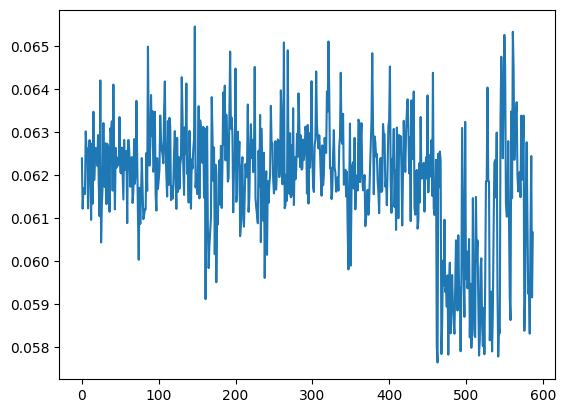

In [18]:
import matplotlib.pyplot as plt

plt.plot(times[1:])

### Compute fps from inference times

In [19]:
import numpy as np


def calculate_fps_stats(inference_times):
    """
    Calculates the average FPS rate and its standard deviation from a list of inference times.

    Args:
        inference_times (list): A list of inference times in seconds.

    Returns:
        tuple: A tuple containing the average FPS rate and its standard deviation.
    """

    # Calculate FPS for each frame
    fps_values = [1 / time for time in inference_times]

    # Calculate average FPS
    average_fps = np.mean(fps_values)

    # Calculate standard deviation of FPS
    std_dev_fps = np.std(fps_values)

    return average_fps, std_dev_fps


average_fps, std_dev_fps = calculate_fps_stats(times)

print("Average FPS:", average_fps)
print("Standard Deviation of FPS:", std_dev_fps)

Average FPS: 16.142290172732356
Standard Deviation of FPS: 0.7541644897674918


### Get model size

In [19]:
import torch


def get_model_size(model_path):
    """
    Calculates the size of an ONNX model in bytes.

    Args:
        model_path (str): The path to the ONNX model file.

    Returns:
        int: The size of the model in bytes.
    """
    if ".onnx" in model_path:
        model = onnx.load(model_path)
        size_bytes = len(model.SerializeToString())
    elif ".pt" in model_path:
        model = torch.load(model_path)
        params = list(model.parameters())
        size_bytes = sum([p.numel() * p.element_size() for p in params])

    # Convert to KB, MB, GB, etc.
    if size_bytes < 1024:
        size_str = f"{size_bytes} B"
    elif size_bytes < 1024 * 1024:
        size_str = f"{size_bytes / 1024:.2f} KB"
    elif size_bytes < 1024 * 1024 * 1024:
        size_str = f"{size_bytes / (1024 * 1024):.2f} MB"
    else:
        size_str = f"{size_bytes / (1024 * 1024 * 1024):.2f} GB"

    return size_str


get_model_size(
    "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/ventral-gait/resnet_fp16.onnx"
)

'46.16 MB'

### Get video characteristics

In [24]:
import cv2


def get_video_characteristics(video_path):
    """
    Extracts the FPS, number of frames, length in seconds, and frame size of a video.

    Args:
        video_path (str): The path to the video file.

    Returns:
        tuple: A tuple containing the FPS, number of frames, length in seconds, and frame size.
    """

    cap = cv2.VideoCapture(video_path)

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) * 0.25
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) * 0.25

    # Calculate video length in seconds
    video_length = frame_count / fps

    cap.release()

    return fps, frame_count, video_length, (frame_width, frame_height)


# Example usage:
video_path = "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/superbird_ssdlite/4782303-hd_1920_1080_25fps.mp4"
fps, frame_count, video_length, frame_size = get_video_characteristics(video_path)

print("FPS:", fps)
print("Number of frames:", frame_count)
print("Video length (seconds):", video_length)
print("Frame size:", frame_size)

FPS: 25.0
Number of frames: 500.0
Video length (seconds): 20.0
Frame size: (480.0, 270.0)
